# Trabajo Computacional 2

In [1]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data
def ldata2(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append([col[0],col[1]])
    return data
def ldata3(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col[1])
    return data

In [171]:


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy
red_proteinas=ldata("tc02Data/yeast_AP-MS.txt")
red_binarias=ldata("tc02Data/yeast_Y2H.txt")
red_literatura=ldata("tc02Data/yeast_LIT.txt")
Esencialidad=ldata3("tc02Data/Essential_ORFs_paperHe.txt")
red_litreguly=ldata2("tc02Data/yeast_LIT_Reguly.txt")



In [3]:
G = nx.Graph()#directed
G.add_edges_from(red_proteinas)
G1 = nx.Graph()#directed
G1.add_edges_from(red_binarias)
G2 = nx.Graph()#directed
G2.add_edges_from(red_literatura)
G3 = nx.Graph()#directed
G3.add_edges_from(red_litreguly)

In [4]:
def K(H):
    k=sum(H.degree(k) for k in H)/H.number_of_nodes()
    salida=[k]
    return salida

In [5]:
data = pd.DataFrame({"Red":["Proteinas","Binarias","Literatura", "Literatura Reg."],
                     "Número de Nodos":[G.number_of_nodes(),G1.number_of_nodes(),G2.number_of_nodes(), G3.number_of_nodes()],
                     "Número de Enlaces":[G.number_of_edges(),G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges()],
                 "Grado medio ":[K(G),K(G1),K(G2),K(G3)],
                 "Clustering promedio":[nx.average_clustering(G),nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3)] })
cols= ['Red', 'Número de Nodos', 'Número de Enlaces', 'Grado medio ','Clustering promedio']

data[cols]


,Red,Número de Nodos,Número de Enlaces,Grado medio,Clustering promedio
0,Proteinas,1622,9070,[11.183723797780518],0.554636
1,Binarias,2018,2930,[2.9038652130822595],0.046194
2,Literatura,1536,2925,[3.80859375],0.292492
3,Literatura Reg.,3309,11859,[7.167724388032639],0.260976


In [5]:
def overlap(J,K):
    a=0
    for j in nx.edges(J):
        for i in nx.edges(K):
            if i==j or i[0]==j[1] and i[1]==j[0]:
                a+=1 
                
    return a/nx.number_of_edges(J), a/nx.number_of_edges(K) 

In [6]:
overlap(G1,G2)

(0.08873720136518772, 0.08888888888888889)

In [7]:
def NodosEsencialesGrado(J,K):
    NE=[]
    k=[]
    for i in nx.nodes(J):
        for j in K:
            if i==j:
                NE.append(i)
                k.append(J.degree(i))
    return k, NE    

In [8]:
def Histograma(J,K):  
    F=NodosEsencialesGrado(J,K)
    plt.hist(F[0],bins=max(F[0]))
    plt.title("Histograma")
    return plt.show()

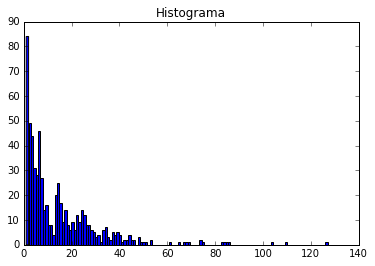

In [62]:
Histograma(G,Esencialidad)

In [9]:
def Zotenko(Grafo,Lista):
    Gcc = sorted(nx.connected_component_subgraphs(Grafo), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = Gcc[0]
    ###Acá seteamos los esenciales y le damos su grado
    #NE=[]
    k=[]
    for i in nx.nodes(G0):
        for j in Lista:
            if i==j:
                #NE.append(i)
                k.append(G0.degree(i))
    #k_NE=[k,NE]
    
    ###Seteamos todos los nodos y su grado
    #N=[]
    K=[]
    for i in nx.nodes(G0):
        #N.append(i)
        K.append(G0.degree(i))
    #k_N=[K,N]
    
    ###Número de hubbs (normalizado) y k0
    A=[]
    #ko=[]
    B=[]
    for k0 in set(K):
        a=0
        for i in K:
            if i>=k0:
                a+=1
        A.append(a/nx.number_of_nodes(G0))
        #ko.append(k0)
        ###El eje y  
        b=0
        for l in k:
            if l>=k0:
                b+=1
        B.append(b/a)
    
    return A,B

In [10]:
Ñ=Zotenko(G,Esencialidad)
Ñ1=Zotenko(G1,Esencialidad)
Ñ2=Zotenko(G2,Esencialidad)
Ñ3=Zotenko(G3,Esencialidad)

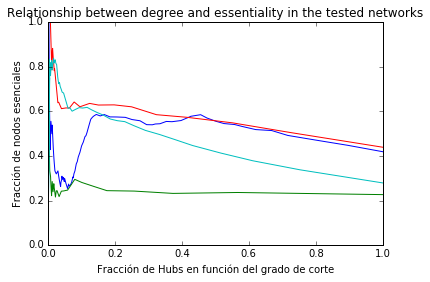

In [14]:
plt.plot(Ñ[0],Ñ[1])
plt.plot(Ñ1[0],Ñ1[1])
plt.plot(Ñ2[0],Ñ2[1])
plt.plot(Ñ3[0],Ñ3[1])
plt.title("Relationship between degree and essentiality in the tested networks")
plt.ylabel("Fracción de nodos esenciales")
plt.xlabel("Fracción de Hubs en función del grado de corte")
plt.show()

In [70]:
def Nnodos (H):    
    Gcc = sorted(nx.connected_component_subgraphs(H), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = Gcc[0] #componente gigante 
    return G0.number_of_nodes() #función que me devuelve el número de nodos de la componente gigante de un grafo
    
def Sacando_nodos(Grafo,GN,NumeroDeNodo):
    G=Grafo
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
    NnodosComponenteGigante=[]
    NodosQueSaco=[]
    N=0
    for g,n in GN:
        if N<NumeroDeNodo-1:#número de nodos menos 1 

            N+=1
            Gcc[0].remove_node(n)
            NnodosComponenteGigante.append(Nnodos(Gcc[0])) #me devuelve el número de nodos de la componente gigante 
            NodosQueSaco.append(N) #me devuelve el número de nodos que saque hasta el momento (=número de pasos)
                                    #ver de dividirlo por el total de nodos
    return NnodosComponenteGigante, NodosQueSaco

def Shuffle_en_nodo(lista,orden,GradoMaximo):  #función que me devuelve lista de grado-nodo pero que shufflea dentro de los nodos de mismo grado 
    GNordenado_shuflle=[]
    RANGO=[i for i in range(GradoMaximo+1)]
    if orden=="AS":
        for i in RANGO:
            GRADO=[]
            NODO=[]

            for j in lista:
                if j[0]==i:
                    GRADO.append(j[0])
                    NODO.append(j[1])

            random.shuffle(NODO)
            a=0
            for h in GRADO:
                GNordenado_shuflle.append([h,NODO[a]])
                a+=1
    else:
        for i in sorted(RANGO,reverse=True):
            GRADO=[]
            NODO=[]

            for j in lista:
                if j[0]==i:
                    GRADO.append(j[0])
                    NODO.append(j[1])

            random.shuffle(NODO)
            a=0
            for h in GRADO:
                GNordenado_shuflle.append([h,NODO[a]])
                a+=1
        
    return GNordenado_shuflle

In [93]:
prueba=ldata("tc02Data/prueba1.txt")
P1=nx.Graph(prueba)

[[0.42857142857142855, 'c'], [0.2857142857142857, 'b'], [0.2857142857142857, 'a'], [0.14285714285714285, 'h'], [0.14285714285714285, 'g'], [0.14285714285714285, 'f'], [0.14285714285714285, 'e'], [0.14285714285714285, 'd']]


['c', 'b', 'a', 'h', 'g', 'f', 'e', 'd']

In [156]:
def DemoliendoRedes(Grafo,NumeroDeNodos,Centralidad,iteraciones):
    G=Grafo
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
    NnodosComponenteGigante=[]
    NodosQueSaco=[]
    N=0
    if Centralidad=="Grado":
        C=nx.degree_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Autovector":
        C=nx.eigenvector_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Subgrafo":
        C=nx.communicability_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="CaminoMasCorto":
        C=nx.betweenness_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Flujo":
        C=nx.current_flow_closeness_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Random":
        NodosCG=[]
        for j in range(iteraciones):
            G_j=Gcc[0].copy()
            Nodos=list(G_j.nodes())
            random.shuffle(Nodos)
            for n in Nodos:
                NnodosCGrandom=[]
                if N<NumeroDeNodos-1:
                    N+=1
                    G_j.remove_node(n)
                    NnodosCGrandom.append(Nnodos(G_j)/NumeroDeNodos)
                    NodosQueSaco.append(N/NumeroDeNodos)
            NodosCG.append(NnodosCGrandom) 
        
        for i in range(NumeroDeNodos-1):
            lista=[]
            for k in range(iteraciones):
                lista.append(NodosCG[k][i])
            NnodosComponenteGigante.append(sum(lista)/iteraciones)
        
        
    return NnodosComponenteGigante, NodosQueSaco        

In [146]:
Centralidades=["Random"]

In [155]:
kaka=[]
for i in Centralidades:
    kaka.append(DemoliendoRedes(G,5,i,2))

IndexError: list index out of range

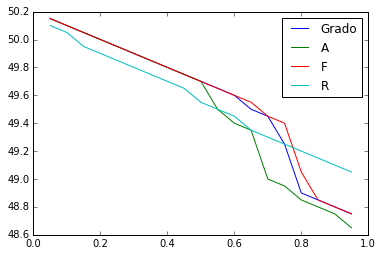

In [136]:

plt.plot(kaka[0][1],kaka[0][0],label="Grado")
plt.plot(kaka[1][1],kaka[1][0],label="A")
plt.plot(kaka[2][1],kaka[2][0],label="c")
plt.plot(kaka[3][1],kaka[3][0],label="F")
plt.plot(kaka[4][1],kaka[4][0],label="R")
plt.legend()
plt.show()

In [160]:
### Faltaría incluir centralidad random, normalizar el tamaño de la componente gigante por el numero de nodos
iteraciones=4
NumeroDeNodos=6

In [178]:
G=G1
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
NnodosComponenteGigante=[]
NodosQueSaco=[]
N=0
NodosCG=[]
for j in range(iteraciones):
    G_j=copy.deepcopy(Gcc[0])
    Nodos=list(G_j.nodes())
    random.shuffle(Nodos)
    for n in Nodos:
        NnodosCGrandom=[]
        if N<NumeroDeNodos-1:
            N+=1
            G_j.remove_node(n)
            NnodosCGrandom.append(Nnodos(G_j)/NumeroDeNodos)
            NodosQueSaco.append(N/NumeroDeNodos)
        print(NnodosCGrandom,j)
    
    NodosCG.append(NnodosCGrandom) 


[274.3333333333333] 0
[273.8333333333333] 0
[273.6666666666667] 0
[273.5] 0
[273.3333333333333] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[] 0
[]

[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1
[] 1


[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3
[] 3


In [177]:
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)

G_k=

In [ ]:
for i in range(NumeroDeNodos-1):
    lista=[]
    for k in range(iteraciones):
        lista.append(NodosCG[k][i])
    NnodosComponenteGigante.append(sum(lista)/iteraciones)